# Sea Clearly: Tracking the pollution originating from aquaculture

Team: The Particle Trackers

Team Leader: Delphine Lobelle

Team Members: Claudio Pierard, Cleo Jongedijk, Darshika Manral, Joey Richardson, Laura Gomez-Navarro, Olmo Zavala-Romero, Victor Onink

## Introduction
This notebook will illustrate the basic concepts behind the Lagrangian simulations of microplastic debris, including the following components:
- Simple example of a Lagrangian simulation
- Forward in time modelling
- Backward in time modelling
- Bayesian analysis
The simple example will illustrate the main model components, but is not set up for full large-scale model simulations due to the time and data constraints for currently running this on the Blue Cloud server. Instead, we use pre-calculated model output that has already by conducted.

The basic model setup is based strongly on [Onink et al. (2021)](https://doi.org/10.1088/1748-9326/abecbd), so for full details please refer to this paper. We use the following reanalysis data, which is all publically available:
- Ocean currents: [CMEMS Mediterranean Sea Physics reanalysis](https://doi.org/10.25423/CMCC/MEDSEA_MULTIYEAR_PHY_006_004_E3R1)


In [114]:
# Importing all relevant packages
from parcels import FieldSet, ParticleSet, ParcelsRandom, ErrorCode, GeographicPolar, Geographic, Field, \
                    JITParticle, Variable, plotTrajectoriesFile
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
from datetime import datetime, timedelta
import numpy as np
from operator import attrgetter
import cartopy.crs as ccrs
import cartopy.feature as cpf
import cmocean.cm as cmo
import pickle
import os

## Running the Lagrangian simulation
### Creating the Fieldset
The Lagrangian simulations are run using the [parcels](https://oceanparcels.org/) python package. For full details on how to use this package, please refer to the various tutorials provided on the OceanParcels website. However, the first step in this process is to create the FieldSet object that contains all the necessary data to run the simulation.

In [2]:
class CreateFieldset:
    def __init__(self):
        self.data_direc = '/Users/victoronink/Desktop/Bern Projects/Blue Cloud Hackathon/Data/'
        self.interpolation = 'linear'
        self.KH = 10                      # horizontal diffusion coefficient, following Onink et al. (2021)
        self.lambda_r = 7                 # Resuspension timescale (days)
        self.lambda_b = 26                # Beaching timescale (days)
        self.dt = timedelta(seconds=30)   # Integration timestep
        self.zone = 6                     # Size of the beaching zone (km)
        
    def create_fieldset(self):
        # Creating the fieldset containing the velocity data
        UV_filenames = {'U': self.data_direc + 'surface_currents.nc', 
                        'V': self.data_direc + 'surface_currents.nc'}
        UV_variables = {'U': 'uo', 'V': 'vo'}
        UV_dimensions = {'U': {'time': 'time', 'depth': 'depth', 'lat': 'lat', 'lon': 'lon'},
                         'V': {'time': 'time', 'depth': 'depth', 'lat': 'lat', 'lon': 'lon'}}

        fieldset = FieldSet.from_netcdf(UV_filenames, UV_variables, UV_dimensions,
                                        allow_time_extrapolation=True, interp_method=self.interpolation)
        
        # Adding the boundary current, which is used to push particles away from shore when they get too close,
        # so that the particles don't get stuck on coastlines due to numerical errors.
        datasetBor = Dataset(self.data_direc + 'boundary_velocities.nc')
        borU = datasetBor.variables['border_u'][0, :, :]
        borV = datasetBor.variables['border_v'][0, :, :]
        fieldset.add_field(Field('borU', borU, lon=datasetBor.variables['lon'], 
                                 lat=datasetBor.variables['lat'], mesh='spherical'))
        fieldset.add_field(Field('borV', borV, lon=datasetBor.variables['lon'][:], 
                                 lat=datasetBor.variables['lat'], mesh='spherical'))
        fieldset.borU.units = GeographicPolar()
        fieldset.borV.units = Geographic()
        
        # Adding a diffusion field, where the horizontal diffusion with fixed diffusion coefficient represents
        # unresolved physical processes that act on smaller horizontal spatial scales than is resolved by the 
        # ocean current data
        land_mask = Dataset(self.data_direc + 'surface_currents.nc').variables['uo'][0, 0, :, :].mask
        Kh_field = np.ones(land_mask.shape) * self.KH
        Kh_field[land_mask] = 0
        fieldset.add_field(Field('Kh_zonal', Kh_field, lon=datasetBor.variables['lon'], 
                                 lat=datasetBor.variables['lat'], mesh='spherical'))
        fieldset.add_field(Field('Kh_meridional', Kh_field, lon=datasetBor.variables['lon'], 
                                 lat=datasetBor.variables['lat'], mesh='spherical'))
        fieldset.add_constant('dres', 0.00005)
        
        # Add the distance to the model shore field, which is used to determine how close a particle is to the 
        # nearest model coastline
        distance = Dataset(self.data_direc + 'distance2coast.nc').variables['distance'][:]
        fieldset.add_field(Field('distance2shore', distance, lon=datasetBor.variables['lon'], 
                                 lat=datasetBor.variables['lat'], mesh='spherical'))
        
        # Adding beaching and resuspension probabilities, along with the size of the beaching zone
        fieldset.add_constant('p_beach', np.exp(-self.dt.total_seconds() / (self.lambda_b * 86400.)))
        fieldset.add_constant('p_resus', np.exp(-self.dt.total_seconds() / (self.lambda_r * 86400.)))
        fieldset.add_constant('Coastal_Boundary', self.zone)
        
        return fieldset
        

### Setting the particle type
Next, we need to set the type of particle we will be modelling. Setting the particle as a JITParticle will help speed up the computations, and we add the `beach` variable to the particle type to be able to differentiate between particles that are adrift or that have beached due to stochastic beaching.

In [3]:
class BaseParticle(JITParticle):
    # 0=adrift, 1=beached
    beach = Variable('beach', dtype=np.int32, initial=attrgetter('beach'))


### Setting particle kernels
We specify the behavior of the microplastic particles using kernels. These parametrize e.g. how a particle beaches and gets resuspended and how we calculate the change in particle position.

In [4]:
def beaching_kernel(particle, fieldset, time):
    """
    The beaching and resuspension kernels for beaching on the coastline follows the procedure outlined in Onink et
    al. (2021) https://doi.org/10.1088/1748-9326/abecbd
    If a floating particle is within the beaching zone, it has a probability of beaching set by fieldset.p_beach.
    Similarly, a beached particle has a probability of being resuspended again, set by fieldset.p_resus. These
    probabilities are set by the beaching and resuspension timescales defined in the fieldset.
    """
    if particle.beach == 0:
        dist = fieldset.distance2shore[time, particle.depth, particle.lat, particle.lon]
        if dist < fieldset.Coastal_Boundary:
            if ParcelsRandom.uniform(0, 1) > fieldset.p_beach:
                particle.beach = 1
    # Now the part where we build in the resuspension
    elif particle.beach == 1:
        if ParcelsRandom.uniform(0, 1) > fieldset.p_resus:
            particle.beach = 0
            
def anti_beach_nudging(particle, fieldset, time):
    """
    If a particle is within 0.5km of the nearest coastline (determined by sampling
    the distance2shore field), then it gets nudged away back out to sea. I have
    fields for border currents, so that the particle gets nudged in the right
    direction with a speed of 1 m s^{-1}.

    With dt=10 minutes a particle gets displaced by 0.5 m back out to sea.
    """
    if fieldset.distance2shore[time, particle.depth, particle.lat, particle.lon] < 0.5:
        borUab = fieldset.borU[time, particle.depth, particle.lat, particle.lon] 
        borVab = fieldset.borV[time, particle.depth, particle.lat, particle.lon]
        particle.lon -= borUab * particle.dt
        particle.lat -= borVab * particle.dt

def floating_advection_rk4(particle, fieldset, time):
    """
    Advection of particles using fourth-order Runge-Kutta integration.
    A particle only moves if it has not beached.
    """
    if particle.beach == 0:
        d2 = particle.depth
        if particle.lon > 180:
            particle.lon -= 360
        if particle.lon < -180:
            particle.lon += 360
        (u1, v1) = fieldset.UV[time, d2, particle.lat, particle.lon]
        lon1, lat1 = (particle.lon + u1 * .5 * particle.dt, particle.lat + v1 * .5 * particle.dt)

        if lon1 > 180:
            lon1 -= 360
        if lon1 < -180:
            lon1 += 360
        (u2, v2) = fieldset.UV[time + .5 * particle.dt, d2, lat1, lon1]
        lon2, lat2 = (particle.lon + u2 * .5 * particle.dt, particle.lat + v2 * .5 * particle.dt)

        if lon2 > 180:
            lon2 -= 360
        if lon2 < -180:
            lon2 += 360
        (u3, v3) = fieldset.UV[time + .5 * particle.dt, d2, lat2, lon2]
        lon3, lat3 = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)

        if lon3 > 180:
            lon3 -= 360
        if lon3 < -180:
            lon3 += 360
        (u4, v4) = fieldset.UV[time + particle.dt, d2, lat3, lon3]

        particle.lon += (u1 + 2 * u2 + 2 * u3 + u4) / 6. * particle.dt
        if particle.lon > 180:
            particle.lon -= 360
        if particle.lon < -180:
            particle.lon += 360
        particle.lat += (v1 + 2 * v2 + 2 * v3 + v4) / 6. * particle.dt


def floating_2d_brownian_motion(particle, fieldset, time):
    """
    Kernel for simple Brownian particle diffusion in zonal and meridional direction.
    Assumes that fieldset has fields Kh_zonal and Kh_meridional
    """
    if particle.beach == 0:
        # Wiener increment with zero mean and std of sqrt(dt)
        dWx = ParcelsRandom.uniform(-1., 1.) * math.sqrt(math.fabs(particle.dt) * 3)
        dWy = ParcelsRandom.uniform(-1., 1.) * math.sqrt(math.fabs(particle.dt) * 3)

        bx = math.sqrt(2 * fieldset.Kh_zonal[time, particle.depth, particle.lat, particle.lon])
        by = math.sqrt(2 * fieldset.Kh_meridional[time, particle.depth, particle.lat, particle.lon])

        particle.lon += bx * dWx
        particle.lat += by * dWy

def delete_particle(particle, fieldset, time):
    """
    In case of an error such as a particle that is out of bounds, this kernel will delete the particle from
    the simulation.
    """
    particle.delete()


def get_particle_behavior(pset):
    """
    Setting the complete particle behavior kernel, where for each integration timestep the kernels run in the order
    they are specified below.
    """
    total_behavior = pset.Kernel(floating_advection_rk4) + \
                     pset.Kernel(floating_2d_brownian_motion) + \
                     pset.Kernel(anti_beach_nudging) + \
                     pset.Kernel(beaching_kernel)
    return total_behavior


### Creating the particle set
Next, we need to create the particle set object, which contain all the particle data within the simulation. This requires us to set the release longitude and latitude coordinates, the number of particles we want to release and the starting time of the simulation. Furthermore, the ParticleSet object requires the FieldSet and particle type to be specified.

In [5]:
class CreateParticleSet:
    def __init__(self, release_lon, release_lat, particle_number, fieldset, particle_type, start_time):
        self.release_lon = release_lon
        self.release_lat = release_lat
        self.particle_number = particle_number
        self.fieldset = fieldset
        self.particle_type = particle_type
        self.start_time = start_time
        
    def create(self):
        lon = [self.release_lon] * self.particle_number
        lat = [self.release_lat] * self.particle_number
        beach = [0] * self.particle_number
        pset = ParticleSet(fieldset=self.fieldset, pclass=self.particle_type, lon=lon, lat=lat,
                           beach=beach, time=self.start_time)
        return pset

### Setting up the simulation
Now that we have specified all the components of the parcels model, we will set the specific parameters for our example case and run it. 

In [15]:
class RunExample:
    def __init__(self):
        # Specify the release locations of the particles, and the number of particles you want to release
        self.release_lon = 11.0
        self.release_lat = 42.2
        self.particle_number = 5
        # Set the starting time of the simulation, the end time and the frequency with which we save the output
        self.start_time = datetime(2010, 1, 1, 0, 0)
        self.end_time = datetime(2010, 1, 2, 0, 0)
        self.simulation_length = (self.end_time - self.start_time).days
        self.output_dt = timedelta(hours=1)
        # Set the random seed for the RNG
        ParcelsRandom.seed(11235811)
        # Create the fieldset object
        self.fieldset = CreateFieldset().create_fieldset()
        # Set the particle type
        self.particle_type = BaseParticle
        # Create the particle set
        self.pset = CreateParticleSet(release_lon=self.release_lon, release_lat=self.release_lat, 
                                      particle_number=self.particle_number, fieldset=self.fieldset, 
                                      particle_type=self.particle_type, start_time=self.start_time).create()
        # Get the particle behavior kernel
        self.kernel = get_particle_behavior(pset=self.pset)
        # Create the output file
        self.output_file = self.pset.ParticleFile(name=self.output_file(), outputdt=self.output_dt)
        
    def run(self):
        self.pset.execute(self.kernel, runtime=timedelta(days=self.simulation_length), dt=CreateFieldset().dt,
                          recovery={ErrorCode.ErrorOutOfBounds: delete_particle},
                          output_file=self.output_file)
        self.output_file.export()
    
    
    @staticmethod 
    def output_file():
        return CreateFieldset().data_direc + 'example_output.nc'
    
RunExample().run()

Now that the simulation has been run, we can take a quick look at the calculated trajectories. As we can see below, the particles are advected towards the west by the ocean currents. However, in order to get a better idea of where microplastic originating from the start location end up, we need to carry out simulations with more particles over longer time periods.

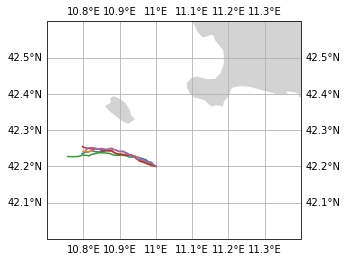

In [7]:
data = xr.load_dataset(RunExample.output_file())
lon, lat = data.lon.values, data.lat.values

fig = plt.figure(1)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent([10.7, 11.4,  42.0,  42.6], crs=ccrs.PlateCarree())
ax.add_feature(cpf.LAND.with_scale('10m'), facecolor='lightgray')
grid=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-')

for trajectory in range(lon.shape[0]):
    ax.plot(lon[trajectory, :], lat[trajectory, :], '-')
    

## Analyzing forward in time model output
The following output was generated with the same basic code as was illustrated before, with the main difference being that each simulation ran for up to 1 year, with 275 particles released at the starting location daily. The increased number of particles increases our confidence in the statistical stability of our results, while releasing particles daily would allow us to look at seasonal effects on microplastic transport.

The figure below shows all the trajectories released from the example site (marked by the red plus, an Italian shellfish aquaculture farm), and tracks where the ocean currents transport these particles for up to 1 year. This gives an illustration where any microplastic originating from an aquaculture site can end up, where this microplastic can be generated from any wear and tear of plastic items (e.g. buoys and nets) within an aquaculture site. While we see seasonal differences, it is clear that even within just a year, microplastic from this site can spread throughout almost the entire Western Mediterranean, which is important to consider in any impact studies of future aquaculture sites.

In [69]:
forward_file = CreateFieldset().data_direc + 'BlueCloudForwards_CMEMS_MEDITERRANEAN_st=26_rt=7_y=2010_LON=11.0_LAT=42.2_r=0_run=0.nc'
data = xr.load_dataset(forward_file)
lon, lat = data.lon.values, data.lat.values

# Seperate the trajectories according to release time
lon_JFM, lat_JFM = lon[:25162, :], lat[:25162, :]
lon_AMJ, lat_AMJ = lon[25162:25162 * 2, :], lat[25162:25162 * 2, :]
lon_JAS, lat_JAS = lon[25162 * 2:25162 * 3, :], lat[25162 * 2:25162 * 3, :]
lon_OND, lat_OND = lon[25162 * 3:, :], lat[25162 * 3:, :]

# Flatten lon/lat arrays
def flatten_non_nan(array):
    """Flatten and remove nan values from an array"""
    is_not_nan = ~np.isnan(array)
    return array[is_not_nan]

flat_lon_JFM, flat_lat_JFM = flatten_non_nan(lon_JFM), flatten_non_nan(lat_JFM)
flat_lon_AMJ, flat_lat_AMJ = flatten_non_nan(lon_AMJ), flatten_non_nan(lat_AMJ)
flat_lon_JAS, flat_lat_JAS = flatten_non_nan(lon_JAS), flatten_non_nan(lat_JAS)
flat_lon_OND, flat_lat_OND = flatten_non_nan(lon_OND), flatten_non_nan(lat_OND)

# Get lon/lat arrays for the histograms
dataset = Dataset(CreateFieldset().data_direc + 'boundary_velocities.nc')
lon_grid, lat_grid = dataset.variables['lon'][:], dataset.variables['lat'][:]
lon_mid, lat_mid = (lon_grid[1:] + lon_grid[:-1]) / 2, (lat_grid[1:] + lat_grid[:-1]) / 2

# Calculate 2D histograms
concentration_JFM, _, _ = np.histogram2d(flat_lon_JFM, flat_lat_JFM, bins=[lon_grid, lat_grid])
concentration_AMJ, _, _ = np.histogram2d(flat_lon_AMJ, flat_lat_AMJ, bins=[lon_grid, lat_grid])
concentration_JAS, _, _ = np.histogram2d(flat_lon_JAS, flat_lat_JAS, bins=[lon_grid, lat_grid])
concentration_OND, _, _ = np.histogram2d(flat_lon_OND, flat_lat_OND, bins=[lon_grid, lat_grid])

# Normalize each concentration array by the maximum value, and then set all 0 values to nan
concentration_list = [concentration_JFM, concentration_AMJ, concentration_JAS, concentration_OND]
for concentration in concentration_list:
    concentration /= np.nanmax(concentration)
    concentration[concentration == 0] = np.nan



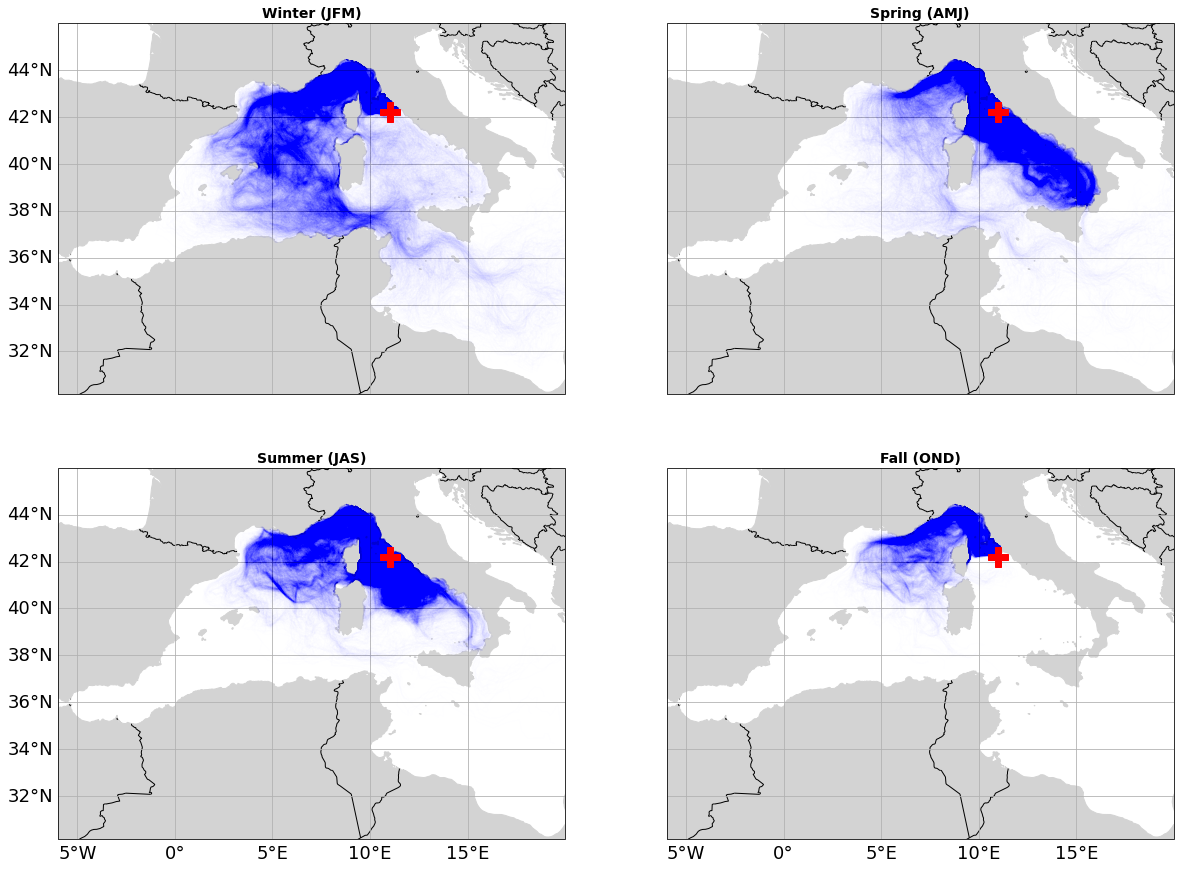

In [128]:
season_lon, season_lat = [lon_JFM, lon_AMJ, lon_JAS, lon_OND], [lat_JFM, lat_AMJ, lat_JAS, lat_OND]
titles = ['Winter (JFM)', 'Spring (AMJ)', 'Summer (JAS)', 'Fall (OND)']

fig = plt.figure(1, figsize=(20, 15))
for season in range(season_lon.__len__()):
    ax = fig.add_subplot(2, 2, season + 1, projection=ccrs.PlateCarree())
    ax.set_extent([-6.0, 20, 30.1875, 45.979168], crs=ccrs.PlateCarree())
    ax.add_feature(cpf.LAND.with_scale('10m'), facecolor='lightgray')
    ax.add_feature(cpf.BORDERS.with_scale('10m'), edgecolor='black')
    grid=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-')
    grid.top_labels = False
    grid.right_labels = False
    if season % 2 == 1:
        grid.left_labels = False
    if season < 2:
        grid.bottom_labels = False
    grid.xlabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}
    grid.ylabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}
    
    ax.set_title(titles[season], fontsize=14, fontweight='bold')

    # Plot the trajectories
    for trajectory in range(season_lon[season].shape[0]):
        ax.plot(season_lon[season][trajectory, ::4], season_lat[season][trajectory, ::4], 
                '-', alpha=1/256, color='blue')

    # # Plot the starting location
    ax.plot(11.0, 42.2, 'rP', zorder=10, markersize=20)
    ax.set_aspect('auto', adjustable=None)


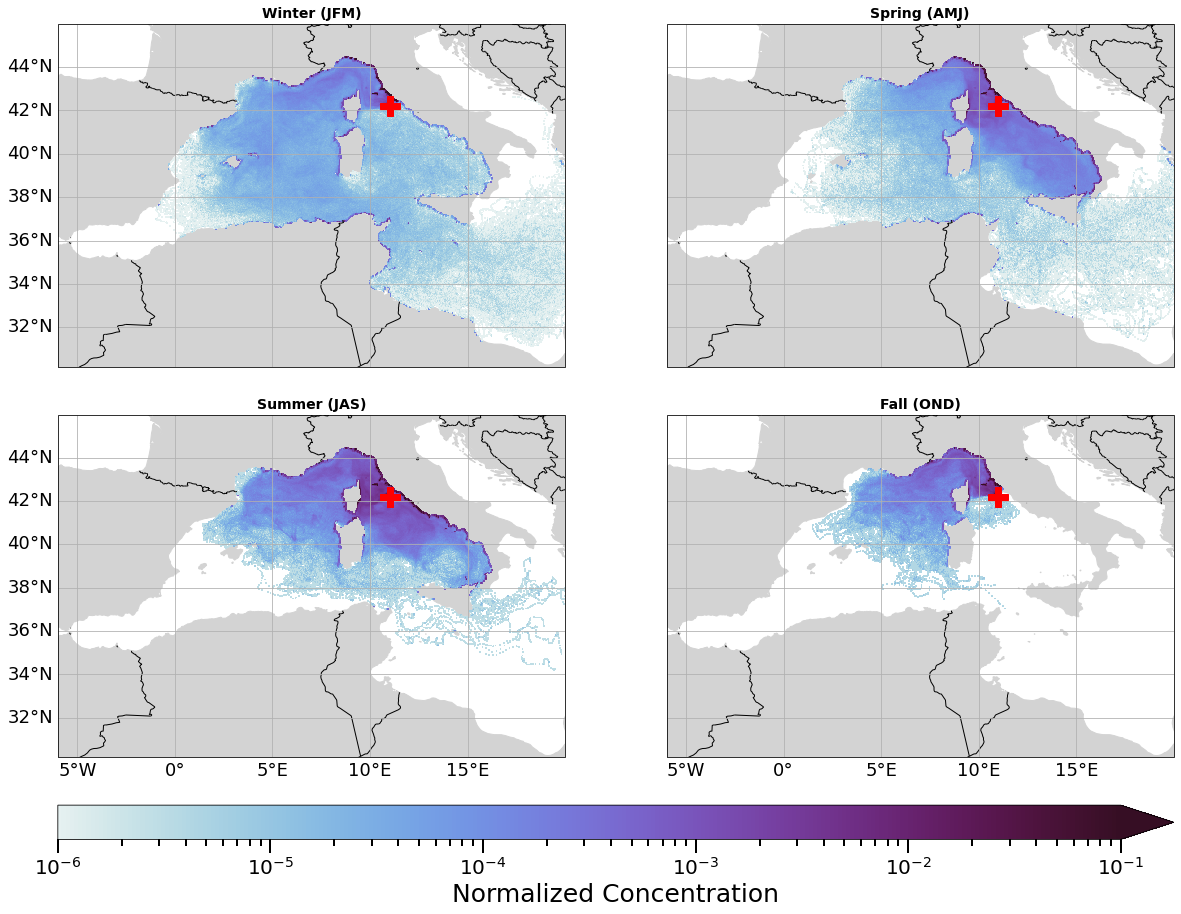

In [126]:
cmap = cmo.dense
norm = colors.LogNorm(vmin=1e-6, vmax=1e-1)

titles = ['Winter (JFM)', 'Spring (AMJ)', 'Summer (JAS)', 'Fall (OND)']

fig = plt.figure(1, figsize=(20, 15))
grid = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1.0, 1.0, 0.1])
ax_list = []
for row in range(2):
    for column in range(2):
        ax_list.append(fig.add_subplot(grid[row, column], projection=ccrs.PlateCarree()))
ax_list.append(fig.add_subplot(grid[-1, :]))

for season in range(season_lon.__len__()):
    ax = ax_list[season]
    ax.set_extent([-6.0, 20, 30.1875, 45.979168], crs=ccrs.PlateCarree())
    ax.add_feature(cpf.LAND.with_scale('10m'), facecolor='lightgray')
    ax.add_feature(cpf.BORDERS.with_scale('10m'), edgecolor='black')
    grid = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-')
    grid.top_labels = False
    grid.right_labels = False
    if season % 2 == 1:
        grid.left_labels = False
    if season < 2:
        grid.bottom_labels = False
    grid.xlabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}
    grid.ylabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}

    ax.set_title(titles[season], fontsize=14, fontweight='bold')

    # Plot the trajectories
    Lat_mid, Lon_mid = np.meshgrid(lat_mid, lon_mid)
    ax.pcolormesh(Lon_mid, Lat_mid, concentration_list[season], cmap=cmap, norm=norm)

    # # Plot the starting location
    ax.plot(11.0, 42.2, 'rP', zorder=10, markersize=20)
    ax.set_aspect('auto', adjustable=None)
        
# Add a colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=ax_list[-1], orientation='horizontal',
                   extend='max')
cbar.set_label('Normalized Concentration', fontsize=25)
cbar.ax.tick_params(which='major', labelsize=20, length=14, width=2)
cbar.ax.tick_params(which='minor', labelsize=20, length=7, width=2)



## Analyzing backward in time model output
While forward in time tracking allows us to evaluate the impact of a given aquaculture site on the surrounding waters, backward integration can provide insight into the origin of any microplastic found at the aquaculture site. Microplastic has been shown to be ingested by marine species such as clams and fish that are part of aquaculture breeding programs, and this backtracking approach provides insight into which microplastic sources contribute most to microplastic found at a given site.  

The basic code for this similation is essentially identical to that for the forward-in-time simulation, where we release 275 particles per day at the aquaculture site (again marked by the red plus). However, we now integrate backwards in time, so that we can trace where a particle would originate from in order to be found at the aquaculture site on the day we released the particle.

In [54]:
backward_file = CreateFieldset().data_direc + 'BlueCloudBackwards_CMEMS_MEDITERRANEAN_st=26_rt=7_y=2010_LON=11.0_LAT=42.2_r=0_run=0.nc'
data = xr.load_dataset(backward_file)
lon, lat = data.lon.values, data.lat.values

# Seperate the trajectories according to release time
lon_OND, lat_OND = lon[:25162, :], lat[:25162, :]
lon_JAS, lat_JAS = lon[25162:25162 * 2, :], lat[25162:25162 * 2, :]
lon_AMJ, lat_AMJ = lon[25162 * 2:25162 * 3, :], lat[25162 * 2:25162 * 3, :]
lon_JFM, lat_JFM = lon[25162 * 3:, :], lat[25162 * 3:, :]

flat_lon_JFM, flat_lat_JFM = flatten_non_nan(lon_JFM), flatten_non_nan(lat_JFM)
flat_lon_AMJ, flat_lat_AMJ = flatten_non_nan(lon_AMJ), flatten_non_nan(lat_AMJ)
flat_lon_JAS, flat_lat_JAS = flatten_non_nan(lon_JAS), flatten_non_nan(lat_JAS)
flat_lon_OND, flat_lat_OND = flatten_non_nan(lon_OND), flatten_non_nan(lat_OND)

# Get lon/lat arrays for the histograms
dataset = Dataset(CreateFieldset().data_direc + 'boundary_velocities.nc')
lon_grid, lat_grid = dataset.variables['lon'][:], dataset.variables['lat'][:]

# Calculate 2D histograms
concentration_JFM, bin_lon, bin_lat = np.histogram2d(flat_lon_JFM, flat_lat_JFM, bins=[lon_grid, lat_grid])
concentration_AMJ, _, _ = np.histogram2d(flat_lon_AMJ, flat_lat_AMJ, bins=[lon_grid, lat_grid])
concentration_JAS, _, _ = np.histogram2d(flat_lon_JAS, flat_lat_JAS, bins=[lon_grid, lat_grid])
concentration_OND, _, _ = np.histogram2d(flat_lon_OND, flat_lat_OND, bins=[lon_grid, lat_grid])

# Normalize each concentration array by the maximum value, and then set all 0 values to nan
for concentration in [concentration_JFM, concentration_AMJ, concentration_JAS, concentration_OND]:
    concentration /= np.nanmax(concentration)
    concentration[concentration == 0] = np.nan


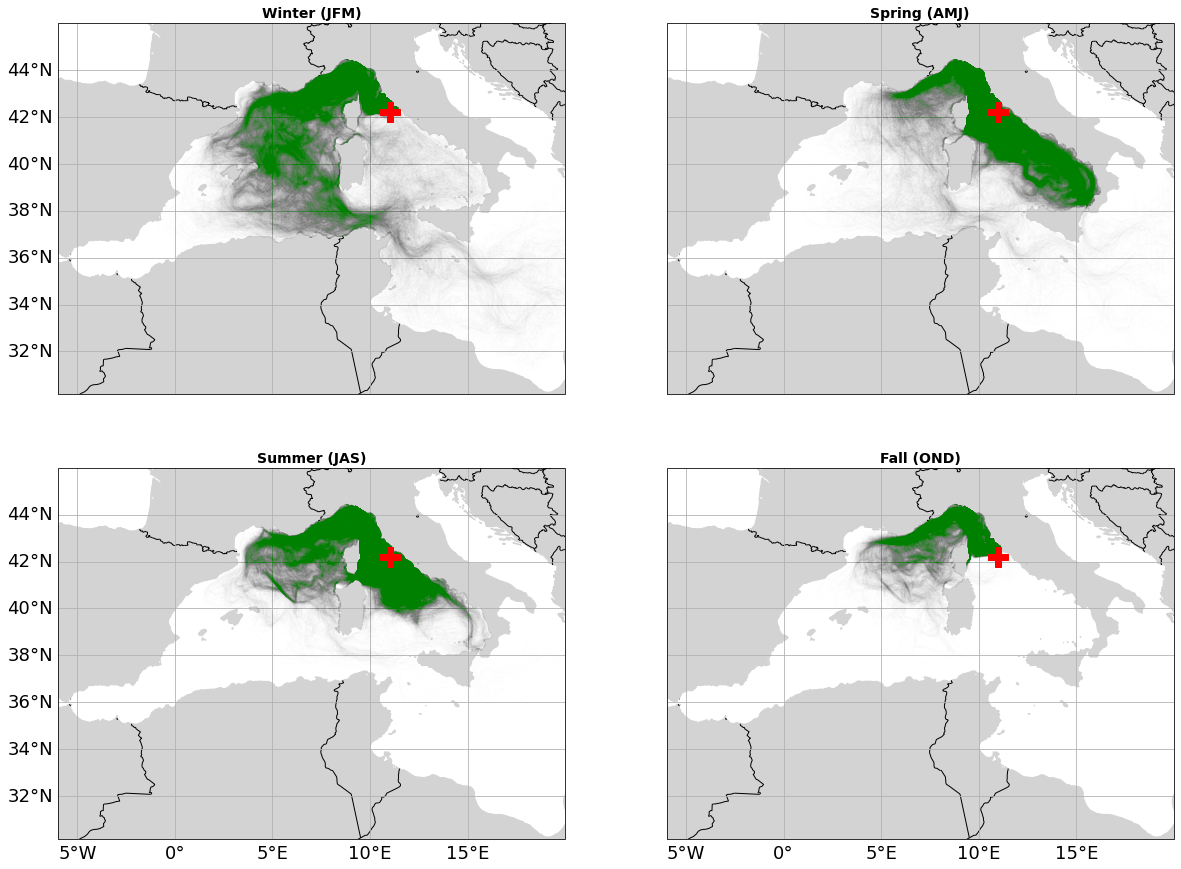

In [127]:
season_lon, season_lat = [lon_JFM, lon_AMJ, lon_JAS, lon_OND], [lat_JFM, lat_AMJ, lat_JAS, lat_OND]
titles = ['Winter (JFM)', 'Spring (AMJ)', 'Summer (JAS)', 'Fall (OND)']

fig = plt.figure(1, figsize=(20, 15))
for season in range(season_lon.__len__()):
    ax = fig.add_subplot(2, 2, season + 1, projection=ccrs.PlateCarree())
    ax.set_extent([-6.0, 20, 30.1875, 45.979168], crs=ccrs.PlateCarree())
    ax.add_feature(cpf.LAND.with_scale('10m'), facecolor='lightgray')
    ax.add_feature(cpf.BORDERS.with_scale('10m'), edgecolor='black')
    grid = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-')
    grid.top_labels = False
    grid.right_labels = False
    if season % 2 == 1:
        grid.left_labels = False
    if season < 2:
        grid.bottom_labels = False
    grid.xlabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}
    grid.ylabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}

    
    ax.set_title(titles[season], fontsize=14, fontweight='bold')

    # Plot the trajectories
    for trajectory in range(season_lon[season].shape[0]):
        ax.plot(season_lon[season][trajectory, ::4], season_lat[season][trajectory, ::4], 
                '-', alpha=1/256, color='green')

    # # Plot the starting location
    ax.plot(11.0, 42.2, 'rP', zorder=10, markersize=20)
    ax.set_aspect('auto', adjustable=None)

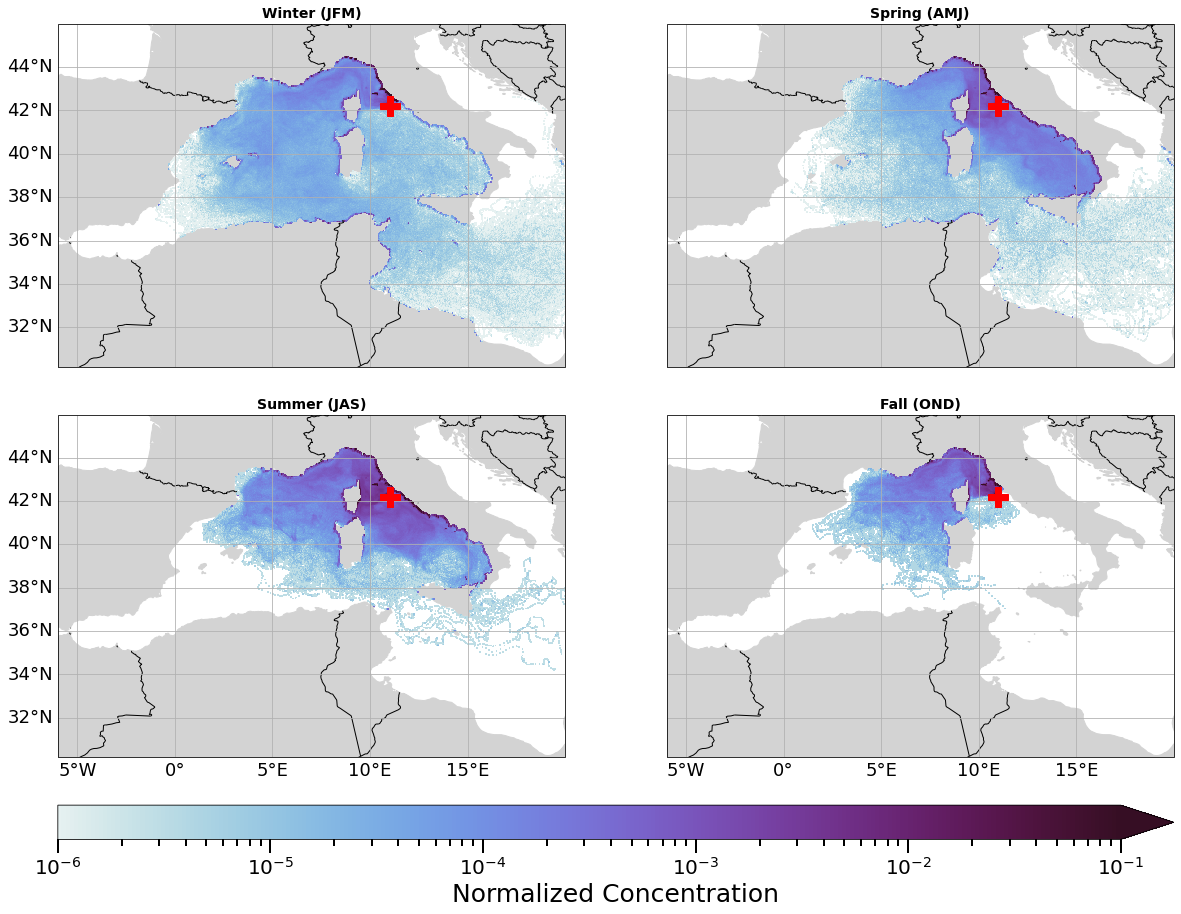

In [125]:
cmap = cmo.dense
norm = colors.LogNorm(vmin=1e-6, vmax=1e-1)

titles = ['Winter (JFM)', 'Spring (AMJ)', 'Summer (JAS)', 'Fall (OND)']

fig = plt.figure(1, figsize=(20, 15))
grid = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[1.0, 1.0, 0.1])
ax_list = []
for row in range(2):
    for column in range(2):
        ax_list.append(fig.add_subplot(grid[row, column], projection=ccrs.PlateCarree()))
ax_list.append(fig.add_subplot(grid[-1, :]))

for season in range(season_lon.__len__()):
    ax = ax_list[season]
    ax.set_extent([-6.0, 20, 30.1875, 45.979168], crs=ccrs.PlateCarree())
    ax.add_feature(cpf.LAND.with_scale('10m'), facecolor='lightgray')
    ax.add_feature(cpf.BORDERS.with_scale('10m'), edgecolor='black')
    grid = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-')
    grid.top_labels = False
    grid.right_labels = False
    if season % 2 == 1:
        grid.left_labels = False
    if season < 2:
        grid.bottom_labels = False
    grid.xlabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}
    grid.ylabel_style = {'size': 18, 'color': 'black', 'weight': 'normal'}

    ax.set_title(titles[season], fontsize=14, fontweight='bold')

    # Plot the trajectories
    Lat_mid, Lon_mid = np.meshgrid(lat_mid, lon_mid)
    ax.pcolormesh(Lon_mid, Lat_mid, concentration_list[season], cmap=cmap, norm=norm)

    # # Plot the starting location
    ax.plot(11.0, 42.2, 'rP', zorder=10, markersize=20)
    ax.set_aspect('auto', adjustable=None)
        
# Add a colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=ax_list[-1], orientation='horizontal',
                   extend='max')
cbar.set_label('Normalized Concentration', fontsize=25)
cbar.ax.tick_params(which='major', labelsize=20, length=14, width=2)
cbar.ax.tick_params(which='minor', labelsize=20, length=7, width=2)



## Bayesian Analysis

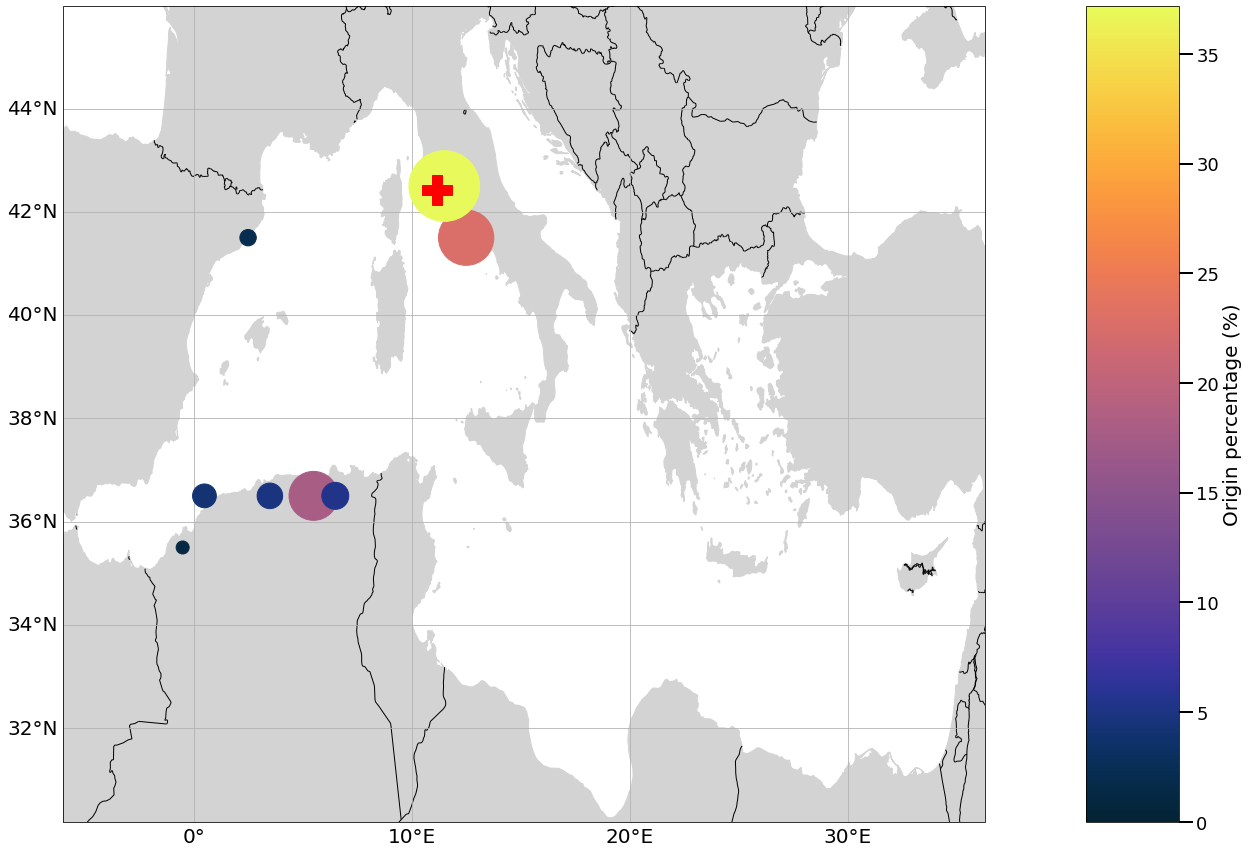

In [124]:
def load_obj(filename):
    if filename[-4:] != '.pkl':
        filename += '.pkl'
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
class BayesianOrigins:
    def __init__(self, site_lon, site_lat):
        # The site lon and lat
        self.site_lon = site_lon
        self.site_lat = site_lat
        # Loading the averaged bayesian file
        self.data_direc = CreateFieldset().data_direc
        self.bayes_dict = load_obj(filename=self.data_direc + 'Averaged_Bayesian.pkl')
        self.LON = self.bayes_dict['LON']
        self.LAT = self.bayes_dict['LAT']
        self.cluster_dict = self.bayes_dict['cluster_dict']
        # Determining the lon and lat indices that are nearest to the site lon and lat
        self.site_lon_ind, self.site_lat_ind = self.get_nearest_index()
        # Get the origin data for the specific cell
        self.site_origins = self.get_origins()
        # Plotting specifications
        self.figure_size = (20, 15)                                 # Size of the figures
        self.ax_label_size = 20                                     # Size of axis labels
        self.ax_ticklabel_size = 18                                 # Size of tick labels on axes
        self.spatial_domain = -6.0, 36.291668, 30.1875, 45.979168   # min_lon, max_lon, min_lat, max_lat
        self.width_ratios = [1, 0.1]                                # ratios of the columns of axes
        self.resolution = '10m'                                     # cartopy feature resolution
        self.cmap = cmo.thermal                                     # origin colormap
        self.cut_off = 1                                            # minimum contribution to origin to be plotted (%)

    def get_nearest_index(self):
        site_lon_ind = np.argmin(np.abs(self.LON - self.site_lon))
        site_lat_ind = np.argmin(np.abs(self.LAT - self.site_lat))
        return site_lon_ind, site_lat_ind

    def get_origins(self):
        site_key = (self.site_lat_ind, self.site_lon_ind)
        if site_key in self.bayes_dict.keys():
            return self.bayes_dict[site_key]
        else:
            print('{} is not a site for which we have data'.format(site_key))

    def plot_origins(self, save_figure=False):
        # Getting the origins, and ordering them from largest to smallest
        cluster_weight, cluster_lon, cluster_lat = [], [], []
        for cluster_id in self.site_origins.keys():
            if cluster_id != 'total':
                weight = self.site_origins[cluster_id] / self.site_origins['total'] * 100
                if weight > self.cut_off:
                    cluster_weight.append(weight)
                    # The cluster dict is set up that for a given cluster_id, it returns a tuple (lon, lat, # particles)
                    cluster_lat.append(self.cluster_dict[cluster_id][0])
                    cluster_lon.append(self.cluster_dict[cluster_id][1])

        # Determining the maximum contribution, which we use to scale the marker sizes
        max_weight = max(cluster_weight)
        cluster_size = [5000 * weight / max_weight for weight in cluster_weight]

        # Creating the figure
        fig = plt.figure(figsize=self.figure_size)
        gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=self.width_ratios)

        # Creating the Mediterranean map
        ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
        lon_min, lon_max, lat_min, lat_max = self.spatial_domain
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax.add_feature(cpf.BORDERS.with_scale(self.resolution), edgecolor='black')
        ax.add_feature(cpf.LAND.with_scale(self.resolution), facecolor='lightgray')
        
        grid = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='-')
        grid.top_labels = False
        grid.right_labels = False
        grid.xlabel_style = {'size': self.ax_label_size, 'color': 'black', 'weight': 'normal'}
        grid.ylabel_style = {'size': self.ax_label_size, 'color': 'black', 'weight': 'normal'}

        # Adding a legend
        norm = colors.Normalize(vmin=0, vmax=max(cluster_weight))
        cmap = plt.cm.ScalarMappable(cmap=self.cmap, norm=norm)
        cax = fig.add_subplot(gs[:, -1])
        cbar = plt.colorbar(cmap, cax=cax, orientation='vertical')
        cbar.set_label("Origin percentage (%)", fontsize=self.ax_label_size)
        cbar.ax.tick_params(which='major', labelsize=self.ax_ticklabel_size, length=14, width=2)
        cbar.ax.tick_params(which='minor', labelsize=self.ax_ticklabel_size, length=7, width=2)

        # Plotting the site location
        ax.plot(self.site_lon, self.site_lat, 'P', color='red', markersize=30, zorder=100)

        # Plotting the origin sites
        ax.scatter(cluster_lon, cluster_lat, cmap=self.cmap, c=cluster_weight, norm=norm, zorder=10,
                   s=cluster_size)

        # Setting the axis
        ax.set_aspect('auto', adjustable=None)

        if save_figure:
            plt.savefig(self.figure_name(), bbox_inches='tight')
        else:
            plt.show()

    def figure_name(self, file_type='.png'):
        return self.data_direc + 'origins_lon_{}_lat_{}'.format(self.site_lon, self.site_lat) + file_type

site_lon_lat = (11.17, 42.43)
BayesianOrigins(*site_lon_lat).plot_origins()